[Latent Dirichlet Allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

The main idea of this notebook is shown an alternative application of LDiA as a dimensional reduction technique and then apply this reduction to a classifier.

In [1]:
from functions import *
import pandas as pd
import numpy as np

#import pyLDAvis
#import pyLDAvis.sklearn
#pyLDAvis.enable_notebook()

Data overview: 

In [2]:
ds= TplPionier(config=config.ds_medium)
colorise=dataset.TplPionierColor()
ds.index.head()

,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,estimated (s),real (s),diff (s),SECONDS
0,2020-12-01 06:58:21.518000+00:00,2020-12-01 07:01:26.742000+00:00,False,PIONIER,bob_ins,PIONIER_gen_tec_scan,True,False,5,2,3,185.0
1,2020-12-01 07:01:24.696000+00:00,2020-12-01 07:01:26.742000+00:00,False,PIONIER,bob_18920,PIONIER_gen_tec_scan,True,False,5,2,3,2.0
2,2020-12-01 07:01:41.277000+00:00,2020-12-01 07:01:43.260000+00:00,False,PIONIER,bob_18920,PIONIER_gen_tec_scan,False,False,5,2,3,1.0
3,2020-12-01 07:02:46.781000+00:00,2020-12-01 07:02:48.675000+00:00,False,PIONIER,bob_18920,PIONIER_gen_tec_scan,False,False,5,2,3,1.0
4,2020-12-01 07:10:51.269000+00:00,2020-12-01 07:20:26.003000+00:00,False,PIONIER,bob_ins,PIONIER_obs_calibrator,False,False,308,935,387,574.0


In [3]:
ds.load_trace(0).head()

,@timestamp,system,envname,keywmask,procname,logtype,event
0,2020-12-01 06:58:21.518000+00:00,PIONIER,wpnr,,bob_ins,LOG,Started at 2020-12-01T06:58:21 (underlined)
1,2020-12-01 06:58:21.741000+00:00,PIONIER,wpnr,,bob_ins,LOG,INS MODE = 'OBSERV-H'
2,2020-12-01 06:58:21.741000+00:00,PIONIER,wpnr,,bob_ins,LOG,ISS IAS HMAG = '6.662'
3,2020-12-01 06:58:21.741000+00:00,PIONIER,wpnr,,bob_ins,LOG,SEQ OPL BEAM3 = '0.0'
4,2020-12-01 06:58:21.741000+00:00,PIONIER,wpnr,,bob_ins,LOG,SEQ OPL BEAM4 = '0.0'


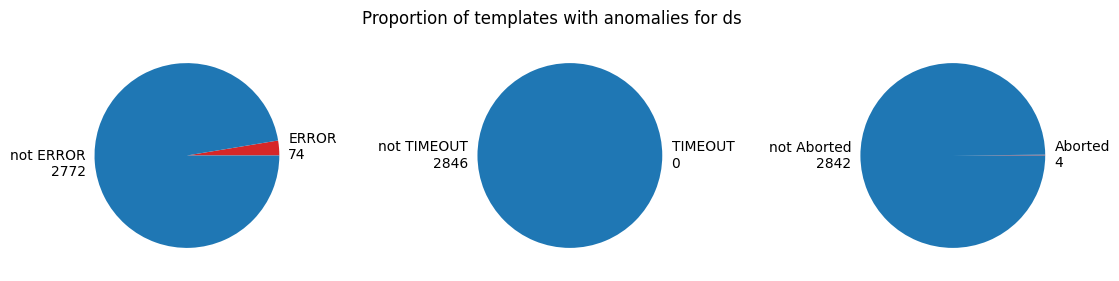

In [6]:
#Camilo function
proportion_pie_from_ds( ds)

Colorisation example:

In [7]:
print(colorise.help())

Colorization class "TplPionierColor"
Inherits from: Paranal1, Numbers, Telescopes, VLTSW, BaseColor

Colorization is done in the following order:

Paranal1: Recommended for Paranal, version 1
    OBS.TARG.NAME "CD_44_3318" -> OBS.TARG.NAME {}
    OBS.PROG.ID "3c5A-24(X)" -> OBS.PROG.ID {}
    OBS.NAME "SCI_NXPup_2" -> OBS.NAME {}
Numbers: Transform numbers in tokens
    -10.54 -> {}
    9.1e-2.1 -> {}
Telescopes: Tokenize telescope related hardware
    wat1tcs -> {watXtcs}
    lat2trk -> {latXtrk}
VLTSW: VLTSW Tokenizers
    cmd321 -> {cmdXXX}  for commands
    bob_492 -> {bob_XXX} bob instances


In [8]:
trace= ds.load_trace(12, cols=['@timestamp','event'])
trace['colour']= trace['event'].apply(colorise.color)

pd.set_option('max_colwidth', 400)
trace[ ['event', 'colour']].head(10)

,event,colour
0,Started at 2020-12-01T07:49:52 (underlined),Started at {} (underlined)
1,PIONIER_obs_calibrator -- Observation of calibrator (yellow),PIONIER_obs_calibrator -- Observation of calibrator (yellow)
2,DPR TECH = 'INTERFEROMETRY',DPR TECH = 'INTERFEROMETRY'
3,"DPR TYPE = 'FRINGE,OBJECT'","DPR TYPE = 'FRINGE,OBJECT'"
4,SEQ NEXPO = '5',SEQ NEXPO = '{}'
5,DPR CATG = 'CALIB',DPR CATG = 'CALIB'
6,SEQ NSCANS = '100',SEQ NSCANS = '{}'
7,STATUS -function DET.READOUT.MODE (blue),STATUS -function DET.READOUT.MODE (blue)
8,"Send command 'STATUS' ',DET.READOUT.MODE,FALSE' to sub-system 'DCS' ...","Send command 'STATUS' ',DET.READOUT.MODE,FALSE' to sub-system 'DCS' ..."
9,"Last Reply to 'STATUS' from 'DCS' received: 'DET.READOUT.MODE ""SIMPLE""' (len='26')",Last Reply to 'STATUS' from 'DCS' received: 'DET.READOUT.MODE {ARG}' (len='{}')


Corpus building

In [9]:
serie= generate_serie(ds,colorise)
serie_pd=pd.DataFrame(serie, columns=['tokens'])
serie_pd.head(2)

,tokens
0,"[Started_at_{}_(underlined), INS_MODE_=_'OBSERV-H', ISS_IAS_HMAG_=_'{}', SEQ_OPL_BEAM3_=_'{}', SEQ_OPL_BEAM4_=_'{}', INS_DISP_NAME_=_'GRISM', TEL_COU_ALPHA_=_'{}', ISS_BASELINE_=_'{}', TEL_COU_EPOCH_=_'{}', SEQ_DL_PRESET_=_'T', ISS_VLTITYPE_=_'snapshot', SEQ_OPL_BEAM1_=_'{}', SEQ_OPL_BEAM2_=_'{}', SEQ_PRESET_=_'T', SEQ_PUPIL_=_'F', TEL_COU_DELTA_=_'{}', AOS_AO_MODE_=_'FULL_AO', TEL_COU_PMA_=_'..."
1,"[Started_at_{}_(underlined), PIONIER_gen_tec_scan_--_Scanning_mode_setup:_Normal_(yellow), DET_DIT_=_'{}', DET_TRK_ST_=_'T', DET_GAIN_=_'HIGH', INS.LAMP2.STOP_Lamp_turned_off., INS.LAMP1.STOP_Lamp_turned_off., STATUS_-function_INS.MODE_(blue), Send_command_'STATUS'_',INS.MODE,FALSE'_to_sub-system_'ICS'_..., Reply_(not_last)_to_'STATUS'_received:_'INS.MODE_PARK'_(len='{}')(last_reply_will_be_ig..."


Using a nested list:

In [10]:
list_tokens_new=[]
for tok in serie_pd.tokens:
    str_tok=" ".join(tok)
    list_tokens_new.append(str_tok)

TF-IDF Vectorization

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer( min_df = 1, max_df=0.5, encoding='utf-8', tokenizer=my_tokenizer)

features= tfidf.fit_transform(list_tokens_new)

print("Number of tokens: ",features.shape[1])
print("Number of traces: ",features.shape[0])

Number of tokens:  879
Number of traces:  2846


In [12]:
df_ds= pd.DataFrame( 
    features.todense(), 
    columns=tfidf.get_feature_names()  
    )
df_ds.head()

,##access_command_done,##setup_command_failed.,##status_command_failed,(obs.name:_dailyalignment_//_obs.id:_{}),(obs.name:_observationconf_//_obs.id:_{}),-_error_performing_command_offsopd_(issprserr_to_wait_brcmd_ready_:_timeout_while_waiting_for_broadcast_command_(offsopd)_ready)._(red),-_waiting_to_complete_cmd_status_on_ics.,"..._calibration{arg}pionier_cal.seq{arg}{}{arg}$revision:_{}_$""_tpl.nexp_{}_tpl.expno_{}_(blue)","..._calibrator{arg}pionier_obs.seq{arg}{}{arg}$revision:_{}_$""_tpl.nexp_{}_tpl.expno_{}_(blue)",..._det.fram.preproc_t_ocs.det.imgname_pionier_gen_ptc_(blue),...,{}_-_ic0fbidevdrvdiscretemotor.c:{}:_iobcy:_scale_factor_=_{},{}_-_ic0fbidevdrvdiscretemotor.c:{}:_loading_icb_configuration,{}_-_ic0fbinsmodel.c:{}:_notice:_irrelevant_setup_key(s)_contained_in_setup_buffer:,{}_-_ic0fbinsmodel.c:{}:_notice:_irrelevant_setup_key_received:_ins.shut5.st,{}_-_ic0fbnamemapping.c:{}:_loading_ws_device_<->_firmware_name_mapping_file:_/vlt/vlt2018/ccslite/config/ic0fbidiscretemotor_twincat.fbmap,{}_-_ic0fbsiaifopcua.c:{}:_disconnected,{}_-_ic0fbsiaifopcua.c:{}:_disconnecting_opcua_session,{}_-_ic0fbsiaifopcua.c:{}:_re-attempting_to_connect_the_session_...,{}_-_ic0fbsiaifopcua.c:{}:_session_reconnected_successfully,{}e-{}_{}e-{}_{}_{}_{}_{}_{}e+{}_{}e+{}_(springgreen4)
0,0.0,0.140245,0.0,0.0,0.102089,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.107695,0.107695,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.198847,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.152696,0.152696,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.321028,0.321028,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.181322,0.181322,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA

t=3

ldia= LDiA( n_components= t, learning_method='batch')
ldia=ldia.fit(df_ds)
ldia.components_.shape

(3, 879)

In [14]:
pd.set_option('display.width', 40)

columns= ['topic{}'.format(i) for i in range(t)]
components= pd.DataFrame(ldia.components_.T, index=df_ds.columns, columns= columns)

components.round(2).head(10)

,topic0,topic1,topic2
##access_command_done,0.33,14.93,0.33
##setup_command_failed.,0.33,1.90,1.09
##status_command_failed,0.33,0.35,10.49
(obs.name:_dailyalignment_//_obs.id:_{}),0.34,0.38,0.33
(obs.name:_observationconf_//_obs.id:_{}),0.33,0.34,7.93
-_error_performing_command_offsopd_(issprserr_to_wait_brcmd_ready_:_timeout_while_waiting_for_broadcast_command_(offsopd)_ready)._(red),0.33,0.33,0.54
-_waiting_to_complete_cmd_status_on_ics.,0.33,0.67,0.44
"..._calibration{arg}pionier_cal.seq{arg}{}{arg}$revision:_{}_$""_tpl.nexp_{}_tpl.expno_{}_(blue)",15.03,0.33,0.33
"..._calibrator{arg}pionier_obs.seq{arg}{}{arg}$revision:_{}_$""_tpl.nexp_{}_tpl.expno_{}_(blue)",17.46,0.33,0.33
..._det.fram.preproc_t_ocs.det.imgname_pionier_gen_ptc_(blue),4.44,0.33,0.33


In [15]:
components.topic1.sort_values(ascending=False)[:15]

{}_-_ic0fbinsmodel.c:{}:_notice:_irrelevant_setup_key_received:_ins.shut5.st                                 89.725052
{}_-_ic0fbinsmodel.c:{}:_notice:_irrelevant_setup_key(s)_contained_in_setup_buffer:                          89.725033
setup_-expoid_{}_-function_det.scan.st_t_(blue)                                                              72.745337
..._det.polar_{}_ins.shut1.st_t_ins.shut2.st_t_ins.shut3.st_t_ins.shut4.st_t_ins.shut5.st_t_(blue)           72.745337
det_dit_=_'{}'                                                                                               71.699041
tplexectimestats:_tpl.id_pionier_gen_tec_scan_estimated_{}:{}:{}_real_{}:{}:{}_diff_{}_seconds_({}:{}:{})    70.012519
template_pionier_gen_tec_scan_finished.                                                                      68.869973
last_reply_to_'status'_from_'dcs'_received:_'det.dl.count_{}'_(len='{}')                                     68.720740
send_command_'status'_',det.dl.count,false'_to_s

In [16]:
ldia_topic_vector= ldia.transform(df_ds)

columns= [ 'topc{}'.format(i) for i in range(ldia.n_components)]

ldia_topic_vector= pd.DataFrame( ldia_topic_vector, columns=columns)

print(ldia_topic_vector.shape)
ldia_topic_vector.round(2).head()

(2846, 3)


,topc0,topc1,topc2
0,0.03,0.19,0.78
1,0.06,0.78,0.16
2,0.06,0.76,0.18
3,0.06,0.88,0.06
4,0.92,0.04,0.04


In [21]:
pyLDAvis.sklearn.prepare(ldia, features, tfidf)

c:\Users\ruben\Desktop\NLP\some-nlp-models\test\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  \
topic                               
1     -0.328194 -0.036341       1   
0      0.199582 -0.233917       2   
2      0.128612  0.270258       3   

       cluster       Freq  
topic                      
1            1  62.378493  
0            1  18.998286  
2            1  18.623220  , topic_info=                                                                                                 Term  \
872                      {}_-_ic0fbinsmodel.c:{}:_notice:_irrelevant_setup_key_received:_ins.shut5.st   
871               {}_-_ic0fbinsmodel.c:{}:_notice:_irrelevant_setup_key(s)_contained_in_setup_buffer:   
275                                                                   ins.lamp1.start_lamp_turned_on.   
171                                                                            calibration_skipped...   
577                                                                                    seq_doit_=_'f'   
..                                                                                                ...   
483  reply_(not_last)_to_'status'_received:_'ins.mode_calib-h'_(len='{}')(last_reply_will_be_ignored)   
235                                                                                dpr_catg_=_'calib'   
237                                                                       dpr_tech_=_'interferometry'   
586                                                                                 seq_nscans_=_'{}'   
585                                                                                  seq_nexpo_=_'{}'   

           Freq       Total Category  \
872  100.000000  100.000000  Default   
871  100.000000  100.000000  Default   
275  164.000000  164.000000  Default   
171   75.000000   75.000000  Default   
577   75.000000   75.000000  Default   
..          ...         ...      ...   
483   54.752228  162.872134   Topic3   
235   40.563578   97.201514   Topic3   
237   38.803300   95.260426   Topic3   
586   38.803300   95.260426   Topic3   
585   38.670577   94.949926   Topic3   

     logprob  loglift  
872  30.0000  30.0000  
871  29.0000  29.0000  
275  28.0000  28.0000  
171  27.0000  27.0000  
577  26.0000  26.0000  
..       ...      ...  
483  -4.0891   0.5906  
235  -4.3891   0.8068  
237  -4.4334   0.7827  
586  -4.4334   0.7827  
585  -4.4368   0.7825  

[138 rows x 6 columns], token_table=      Topic      Freq  \
term                    
11        2  0.995464   
12        3  0.983284   
14        3  0.986443   
15        3  0.983284   
17        3  0.986443   
...     ...       ...   
871       2  0.952171   
871       3  0.039674   
872       2  0.952170   
872       3  0.039674   
878       2  0.975292   

                                                                                                                                                                          Term  
term                                                                                                                                                                            
11                                                                          ..._det.polar_{}_ins.shut1.st_t_ins.shut2.st_t_ins.shut3.st_t_ins.shut4.st_t_ins.shut5.st_t_(blue)  
12    ..._det.subwin12.geometry_{}x1+{}+{}_det.subwin36.geometry_{}x1+{}+{}_det.subwin13.geometry_{}x1+{}+{}_det.subwin37.geometry_{}x1+{}+{}_det.subwin14.geometry_{}x1+{}+{}  
14    ..._det.subwin14.geometry_{}x1+{}+{}_det.subwin15.geometry_{}x1+{}+{}_det.subwin16.geometry_{}x1+{}+{}_det.subwin17.geometry_{}x1+{}+{}_det.subwin18.geometry_{}x1+{}+{}  
15    ..._det.subwin17.geometry_{}x1+{}+{}_det.subwin41.geometry_{}x1+{}+{}_det.subwin18.geometry_{}x1+{}+{}_det.subwin42.geometry_{}x1+{}+{}_det.subwin19.geometry_{}x1+{}+{}  
17    ..._det.subwin19.geometry_{}x1+{}+{}_det.subwin20.geometry_{}x1+{}+{}_det.subwin21.geometry_{}x1+{}+{}_det.subwin22.geometry_{}x1+{}+{}_det.subwin23.geometry_{}x1+{}+{}  

#### Data split

In [22]:
train_indexes, test_indexes=split_subds( ds.index, train_prop=.75)
ds.index= df_split(ds.index, train_indexes)
ds.index.loc[:, ['TPL_ID','ERROR','split']]

,TPL_ID,ERROR,split
0,PIONIER_gen_tec_scan,True,test
1,PIONIER_gen_tec_scan,True,train
2,PIONIER_gen_tec_scan,False,test
3,PIONIER_gen_tec_scan,False,train
4,PIONIER_obs_calibrator,False,train
...,...,...,...
2841,PIONIER_gen_tec_setup,False,train
2842,PIONIER_gen_tec_standby,False,test
2843,PIONIER_gen_tec_setup,False,train
2844,PIONIER_gen_tec_fluxopt,False,train


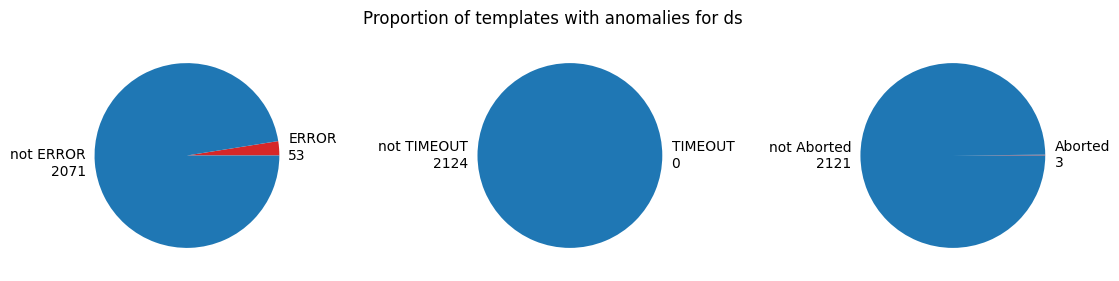

In [23]:
#Camilo function
proportion_pie_from_ds_v2( ds.index[ds.index['split']=='train'] ) 

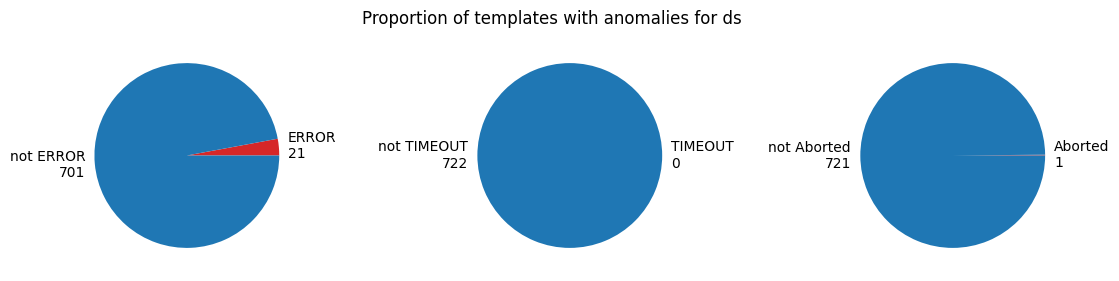

In [24]:
#Camilo function
proportion_pie_from_ds_v2( ds.index[ds.index['split']=='test'] ) 

#### LDA using LDiA

LDA: Linear Discriminant Analysis as its name suggests is a linear model for classification and dimensionality reduction.  Most commonly used for feature extraction in pattern classification problems. LDA projects data from a D dimensional feature space down to a D’ (D>D’) dimensional space in a way to maximize the variability between the classes and reducing the variability within the classes. [source](https://www-analyticsvidhya-com.translate.goog/blog/2021/08/a-brief-introduction-to-linear-discriminant-analysis/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=sc)

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#split data
X_train=ldia_topic_vector.iloc[ train_indexes,:]
X_test=ldia_topic_vector.iloc[ test_indexes,:]

y_train=ds.index[ ds.index['split']=='train']['ERROR']
y_test=ds.index[ ds.index['split']=='test']['ERROR']

model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
grid['shrinkage']= arange(0,1,0.01)
# define search
search = GridSearchCV(model, grid, scoring='recall', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.000
Config: {'shrinkage': 0.0, 'solver': 'lsqr'}


c:\Users\ruben\Desktop\NLP\some-nlp-models\test\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3013 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ruben\Desktop\NLP\some-nlp-models\test\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ruben\Desktop\NLP\some-nlp-models\test\lib\site-packages\sklearn\discriminant_analysis.py", line 589, in fit
    raise NotImplementedError("shrinkage not supported")
NotImplementedError: shrinkage not supported

-----------------------------

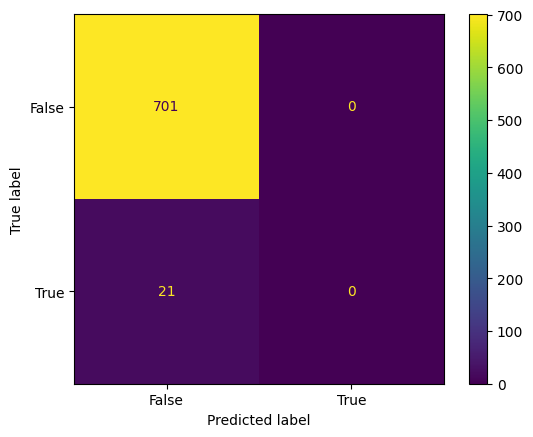

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics


cm= metrics.confusion_matrix(y_test, search.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=search.classes_)
disp.plot()

We have no predictions on True label! This could be because this algorithm is very sensible to data imbalance.

In [27]:
from sklearn.metrics import classification_report

metric= classification_report(y_test, search.predict(X_test), output_dict=True)
metric

c:\Users\ruben\Desktop\NLP\some-nlp-models\test\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ruben\Desktop\NLP\some-nlp-models\test\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ruben\Desktop\NLP\some-nlp-models\test\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

{'False': {'precision': 0.9709141274238227,
  'recall': 1.0,
  'f1-score': 0.9852424455375965,
  'support': 701},
 'True': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21},
 'accuracy': 0.9709141274238227,
 'macro avg': {'precision': 0.48545706371191133,
  'recall': 0.5,
  'f1-score': 0.4926212227687983,
  'support': 722},
 'weighted avg': {'precision': 0.9426742428311631,
  'recall': 0.9709141274238227,
  'f1-score': 0.9565858093100487,
  'support': 722}}

### K-NN: 

K-Nearest Neighbour is one of the simplest Machine Learning algorithms based on Supervised Learning technique. It
 assumes the similarity between the new case/data and available cases and put the new case into the category that is most similar to the available categories.
K-NN algorithm stores all the available data and classifies a new data point based on the similarity. This means when new data appears then it can be easily classified into a well suite category by using K- NN algorithm.
This algorithm can be used for Regression as well as for Classification but mostly it is used for the Classification problems [source](https://www.javatpoint.com/k-nearest-neighbor-algorithm-for-machine-learning)

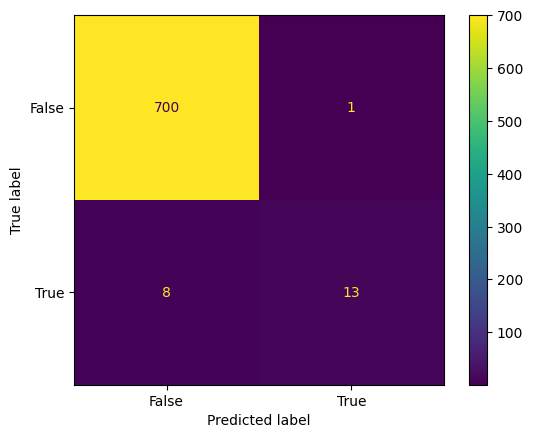

In [30]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors=4

knn = KNeighborsClassifier(n_neighbors)
model_knn=knn.fit(X_train, y_train)

cm_knn= metrics.confusion_matrix(y_test, model_knn.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,display_labels=model_knn.classes_)
disp.plot()

In [31]:
metric= classification_report(y_test, model_knn.predict(X_test), output_dict=True)
metric

{'False': {'precision': 0.9887005649717514,
  'recall': 0.9985734664764622,
  'f1-score': 0.9936124911284598,
  'support': 701},
 'True': {'precision': 0.9285714285714286,
  'recall': 0.6190476190476191,
  'f1-score': 0.742857142857143,
  'support': 21},
 'accuracy': 0.9875346260387812,
 'macro avg': {'precision': 0.9586359967715901,
  'recall': 0.8088105427620407,
  'f1-score': 0.8682348169928014,
  'support': 722},
 'weighted avg': {'precision': 0.986951656572296,
  'recall': 0.9875346260387812,
  'f1-score': 0.9863190530208453,
  'support': 722}}

In [17]:
topic_distribution = ldia.transform(df_ds)
topic_assignments = topic_distribution.argmax(axis=1)

In [20]:
topic_counts = pd.Series(topic_assignments).value_counts().sort_index()
trace_counts = df_ds.shape[0]
topic_trace_counts = []
for i in range(ldia.n_components):
    topic_trace_counts.append(topic_counts[i::ldia.n_components].sum())

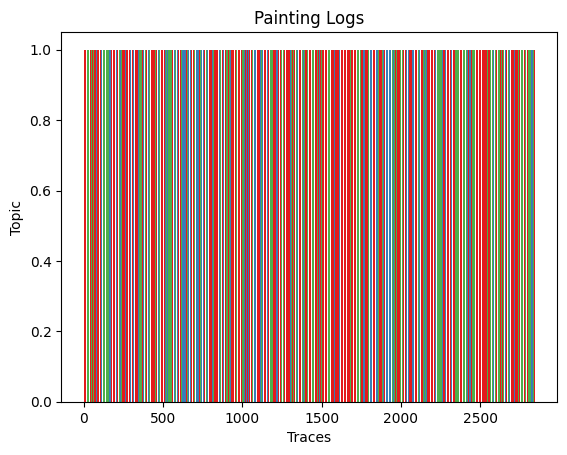

In [22]:
fig, ax = plt.subplots()
ax.bar(range(trace_counts), [1]*trace_counts, color=[plt.cm.Set1(i) for i in topic_assignments])
ax.set_xlabel('Traces')
ax.set_ylabel('Topic')
ax.set_title('Painting Logs')
plt.show()


Much better results! we went from making no predictions about 0 class to havin a recall over 0.9!